In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow.keras as keras
import json
import os
from zipfile import ZipFile

In [3]:
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install kaggle

In [ ]:
kaggle_credentials = json.load(open("kaggle.json"))

In [ ]:
#kaggle API credentials
os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

In [ ]:
#downloads dataset from kaggle
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

In [ ]:
#unzip dataset
with ZipFile("new-plant-diseases-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

<H4>Data Preprocessing
<H5> Training set preprocessing

In [4]:
training_set = keras.utils.image_dataset_from_directory(
    'Plant_Diseases_Dataset/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 70295 files belonging to 38 classes.


<H4> Validation set processing 

In [5]:
for x,y in training_set:
    print(x,x.shape)
    print(y,y.shape)
    break

tf.Tensor(
[[[[134. 132. 146.]
   [132. 130. 144.]
   [131. 129. 143.]
   ...
   [ 96.  97. 118.]
   [101. 102. 123.]
   [106. 107. 128.]]

  [[134. 132. 146.]
   [133. 131. 145.]
   [131. 129. 143.]
   ...
   [ 97.  98. 119.]
   [100. 101. 122.]
   [104. 105. 126.]]

  [[137. 135. 149.]
   [136. 134. 148.]
   [134. 132. 146.]
   ...
   [ 99. 100. 121.]
   [100. 101. 122.]
   [102. 103. 124.]]

  ...

  [[109. 103. 117.]
   [119. 113. 127.]
   [ 95.  89. 103.]
   ...
   [132. 148. 112.]
   [ 99. 116.  74.]
   [101. 118.  73.]]

  [[103.  97. 111.]
   [ 93.  87. 101.]
   [120. 114. 128.]
   ...
   [144. 159. 126.]
   [ 98. 114.  75.]
   [ 91. 108.  64.]]

  [[120. 114. 128.]
   [101.  95. 109.]
   [ 85.  79.  93.]
   ...
   [ 94. 109.  76.]
   [117. 133.  96.]
   [100. 117.  75.]]]


 [[[146. 147. 167.]
   [126. 127. 147.]
   [138. 139. 159.]
   ...
   [119. 119. 147.]
   [117. 117. 145.]
   [117. 117. 145.]]

  [[139. 140. 160.]
   [136. 137. 157.]
   [150. 151. 171.]
   ...
   [125. 1

In [3]:
validation_set = keras.utils.image_dataset_from_directory(
    'Plant_Diseases_Dataset/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 17572 files belonging to 38 classes.


<h4> Building convolutional neural network

In [9]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Sequential

In [10]:
#definition of the model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation = 'relu', input_shape=[256, 256, 3]))
model.add(Conv2D(32, (3, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation = 'relu'))
model.add(Conv2D(64,(3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation = 'relu'))
model.add(Conv2D(128,(3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Conv2D(filters=256, kernel_size=3, padding='same',activation = 'relu'))
model.add(Conv2D(256,(3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Conv2D(filters=512, kernel_size=3, activation = 'relu'))
model.add(Conv2D(512,(3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Dropout(0.25))

#flattens to one dimension array for the output layers
model.add(Flatten())
model.add(Dense(units=1500, activation='relu'))

model.add(Dropout(0.4))

#output layer
model.add(Dense(units=38, activation='softmax'))

<h4> Compile model

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 254, 254, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 127, 127, 64)      18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

<H4> Model training

In [13]:
training_history = model.fit(x=training_set, validation_data=validation_set, epochs=5)

Epoch 1/5
2197/2197 [==============================] - 330s 145ms/step - loss: 1.1614 - accuracy: 0.6556 - val_loss: 0.5230 - val_accuracy: 0.8319
Epoch 2/5
2197/2197 [==============================] - 313s 142ms/step - loss: 0.3748 - accuracy: 0.8804 - val_loss: 0.2591 - val_accuracy: 0.9138
Epoch 3/5
2197/2197 [==============================] - 313s 142ms/step - loss: 0.2105 - accuracy: 0.9317 - val_loss: 0.1828 - val_accuracy: 0.9409
Epoch 4/5
2197/2197 [==============================] - 313s 142ms/step - loss: 0.1376 - accuracy: 0.9545 - val_loss: 0.1471 - val_accuracy: 0.9531
Epoch 5/5
2197/2197 [==============================] - 313s 142ms/step - loss: 0.1053 - accuracy: 0.9648 - val_loss: 0.2060 - val_accuracy: 0.9394


<H4> Model evaluation

In [14]:
train_loss, train_accuracy = model.evaluate(training_set)

2197/2197 [==============================] - 90s 41ms/step - loss: 0.0993 - accuracy: 0.9700


In [15]:
print(train_loss, train_accuracy)

0.0992564857006073 0.9699978828430176


In [16]:
validation_loss, validation_accuracy = model.evaluate(validation_set)

550/550 [==============================] - 22s 40ms/step - loss: 0.2060 - accuracy: 0.9394


In [17]:
print(validation_loss, validation_accuracy)

0.20595890283584595 0.9394491314888


<H4> Save model

In [ ]:
from keras import Model

model.save(filepath="trained_model/trained_disease_detection.keras", overwrite=True, save_format="keras")

In [ ]:
training_history.history

<h5> Recording history in JSON

In [ ]:
import json
with open("training_history.json", "w") as f:
    json.dump(training_history.history, f)

<H4> Visualizations and Metrics

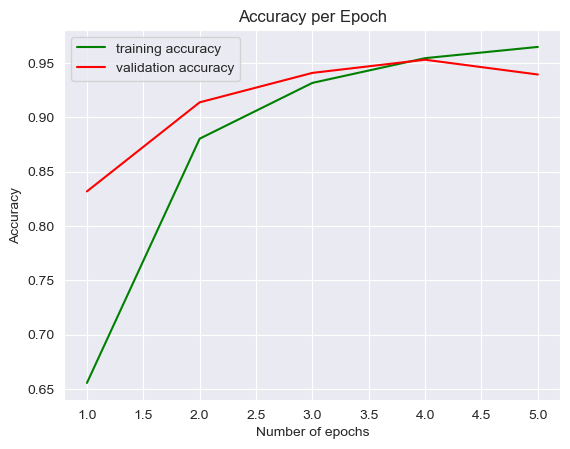

In [18]:
epochs = [i for i in range(1,6)]
plt.plot(epochs, training_history.history['accuracy'], color='green', label="training accuracy")
plt.plot(epochs, training_history.history['val_accuracy'], color='red', label="validation accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()

In [4]:
class_name = validation_set.class_names
class_name

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [20]:
test_set = keras.utils.image_dataset_from_directory(
    'Plant_Diseases_Dataset/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
) 

Found 17572 files belonging to 38 classes.


In [21]:
y_pred = model.predict(test_set)
y_pred

550/550 [==============================] - 21s 38ms/step


array([[9.9999976e-01, 2.1479817e-10, 2.1764862e-11, ..., 4.0047074e-14,
        2.6858707e-14, 6.7043784e-12],
       [9.9999928e-01, 3.9051645e-08, 2.0634217e-09, ..., 9.9249125e-13,
        7.8203798e-12, 3.3260030e-09],
       [1.0000000e+00, 1.5490571e-12, 1.2161223e-11, ..., 6.5261914e-16,
        5.9049060e-15, 4.4358068e-12],
       ...,
       [6.5431395e-13, 8.1327116e-14, 5.6517763e-11, ..., 1.7088026e-12,
        9.0340539e-13, 1.0000000e+00],
       [4.6580784e-11, 9.7349281e-12, 7.2767625e-11, ..., 1.5809246e-11,
        5.9474040e-12, 1.0000000e+00],
       [1.6878902e-15, 7.5779928e-17, 1.2272403e-17, ..., 1.0062635e-16,
        3.8233934e-12, 9.9999988e-01]], dtype=float32)

In [22]:
predicted_cats = tf.argmax(y_pred, axis=1)

In [23]:
true_cats = tf.concat([y for x,y in test_set], axis=0)
true_cats

<tf.Tensor: shape=(17572, 38), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)>

In [24]:
Y_true = tf.argmax(true_cats, axis=1)
Y_true

<tf.Tensor: shape=(17572,), dtype=int64, numpy=array([ 0,  0,  0, ..., 37, 37, 37], dtype=int64)>

In [25]:
from sklearn.metrics import classification_report, confusion_matrix


In [26]:
print(classification_report(Y_true, predicted_cats, target_names=class_name))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.93      0.94       504
                                 Apple___Black_rot       1.00      0.98      0.99       497
                          Apple___Cedar_apple_rust       0.97      0.98      0.98       440
                                   Apple___healthy       0.96      0.93      0.95       502
                               Blueberry___healthy       0.98      0.98      0.98       454
          Cherry_(including_sour)___Powdery_mildew       0.94      0.99      0.96       421
                 Cherry_(including_sour)___healthy       0.97      0.99      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.81      0.96      0.88       410
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.97      0.81      0.

In [27]:
cm = confusion_matrix(Y_true, predicted_cats)
cm

array([[469,   0,   1, ...,   0,   0,   0],
       [  1, 486,   0, ...,   0,   0,   0],
       [  0,   0, 432, ...,   1,   0,   1],
       ...,
       [  0,   0,   0, ..., 484,   0,   0],
       [  0,   0,   0, ...,   0, 445,   1],
       [  0,   0,   0, ...,   0,   0, 480]], dtype=int64)

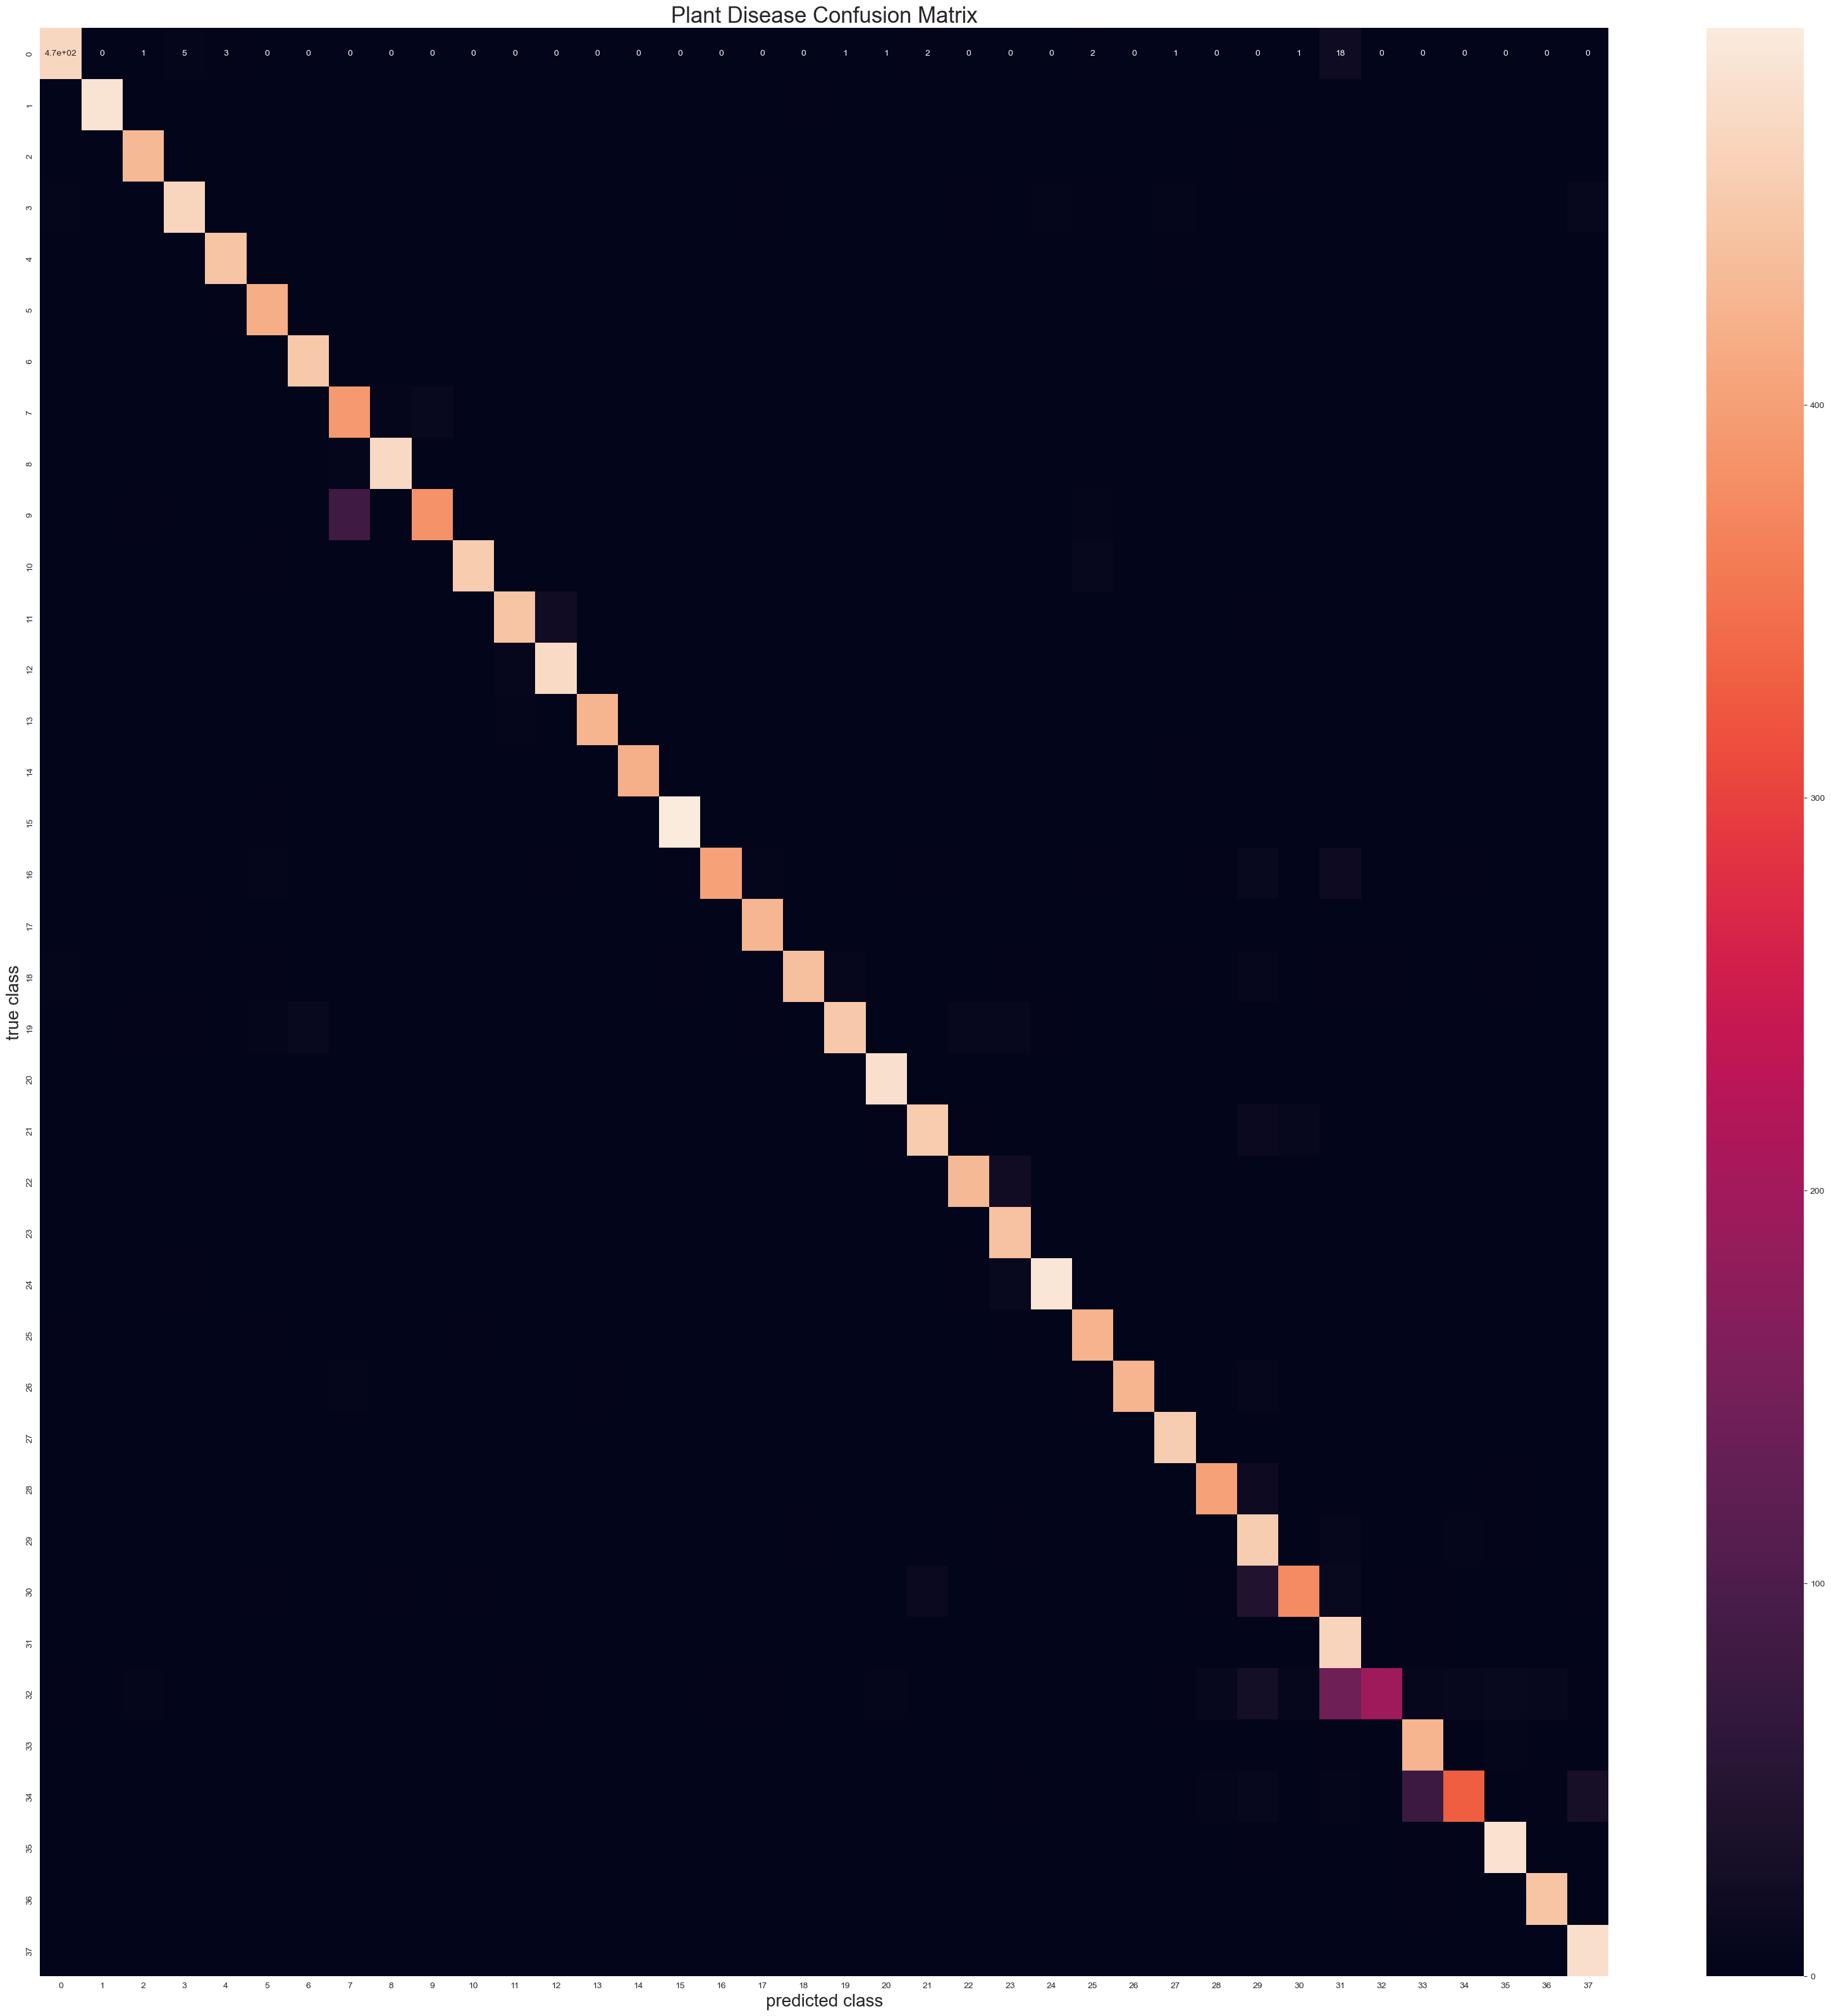

In [28]:
from IPython.core.pylabtools import figsize

plt.figure(figsize(40,40))
sns.heatmap(cm, annot=True, annot_kws={'size':10})
plt.xlabel("predicted class", fontsize=20)
plt.ylabel("true class", fontsize=20)
plt.title("Plant Disease Confusion Matrix", fontsize=25)
plt.show()